<a href="https://colab.research.google.com/github/shaina-12/Knee-Ostheoarthritis-Detection-and-Severity-Prediction/blob/main/Experiment%202/Knee_Osteoarthritis_Detection_and_Severity_Prediction_2nd_Experiment_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import cv2 as cv
import os
from sklearn.cluster import KMeans
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train_path = "/content/drive/My Drive/train/"
test_path = "/content/drive/My Drive/test/"

## Lets Collect The Training Data

In [4]:
grades = ['grade_0','grade_1','grade_2','grade_3','grade_4']
finalListTrain = []
finalTrainLabels = []
for i in range(len(grades)):
    dir_join = train_path+grades[i]
    for file in os.listdir(dir_join):
        finalListTrain.append(dir_join+'//'+file)
        finalTrainLabels.append(i)
#dir_join = train_path+grades[0]  
#l = os.listdir(os.path.join(dir_join))
#l

## Similarly, we can collect the test data

In [5]:
finalListTest = []
finalTestLabels = []
for i in range(len(grades)):
    dir_join = test_path+grades[i]
    for file in os.listdir(dir_join):
        finalListTest.append(dir_join+'//'+file)
        finalTestLabels.append(i)

## Lets create pandas dataframe for both training and test data

In [6]:
train_dat = {'path':finalListTrain,'label':finalTrainLabels}
test_dat = {'path':finalListTest,'label':finalTestLabels}

In [7]:
train_data = pd.DataFrame.from_dict(train_dat)
train_data.head()

path  label
0  /content/drive/My Drive/train/grade_0//9512848...      0
1  /content/drive/My Drive/train/grade_0//9465265...      0
2  /content/drive/My Drive/train/grade_0//9679243...      0
3  /content/drive/My Drive/train/grade_0//9302341...      0
4  /content/drive/My Drive/train/grade_0//9023407...      0

In [8]:
test_data = pd.DataFrame.from_dict(test_dat)
test_data.head()

path  label
0  /content/drive/My Drive/test/grade_0//9807132L...      0
1  /content/drive/My Drive/test/grade_0//9588277L...      0
2  /content/drive/My Drive/test/grade_0//9074232L...      0
3  /content/drive/My Drive/test/grade_0//9952817R...      0
4  /content/drive/My Drive/test/grade_0//9254422R...      0

## Time for Data Analysis

In [9]:
type(train_data)

pandas.core.frame.DataFrame

In [10]:
train_data.count()

path     6621
label    6621
dtype: int64

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6621 entries, 0 to 6620
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    6621 non-null   object
 1   label   6621 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 103.6+ KB


In [12]:
train_data.shape

(6621, 2)

In [13]:
test_data.count()

path     1656
label    1656
dtype: int64

In [14]:
test_data.shape

(1656, 2)

In [15]:
df = pd.DataFrame()
df['ostheoarthritis grading'] = ['Grade 0','Grade 1','Grade 2','Grade 3','Grade 4']
grade_count = []
for i in range(5):
    gc = len(train_data[train_data['label']==i]) + len(test_data[test_data['label']==i])
    grade_count.append(gc)
df['count (both training and testing)'] = grade_count[:]
df

ostheoarthritis grading  count (both training and testing)
0                 Grade 0                               3270
1                 Grade 1                               1495
2                 Grade 2                               2175
3                 Grade 3                               1086
4                 Grade 4                                251

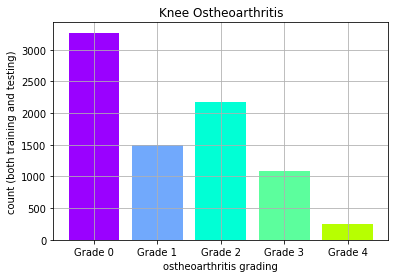

In [16]:
x = list(np.arange(5))
y = list(df['count (both training and testing)'])
plt.bar(x,y,color=['#9a01ff','#71a9fc','#01ffd5','#5cfe9d','#b7ff01'])
plt.grid()
plt.xticks(x,list(df['ostheoarthritis grading']))
plt.xlabel('ostheoarthritis grading')
plt.ylabel('count (both training and testing)')
plt.title('Knee Ostheoarthritis')
plt.show()

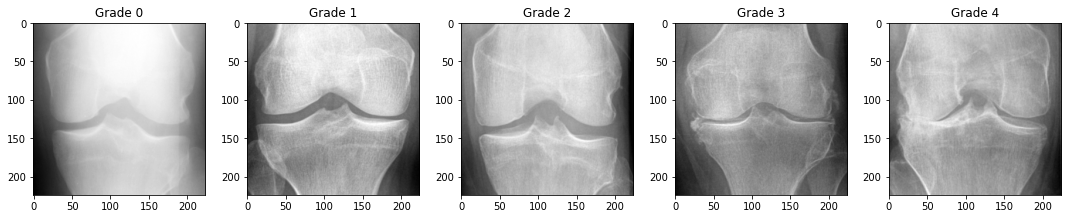

In [17]:
fig, ax = plt.subplots(1,5,figsize=(15,15))
ax = ax.ravel()
plt.tight_layout()
ax = ax.ravel()
plt.tight_layout()
ldata = ['/content/drive/My Drive/train/grade_0/9005656L.png',
         '/content/drive/My Drive/train/grade_1/9008561R.png',
        '/content/drive/My Drive/train/grade_2/9024940L.png',
        '/content/drive/My Drive/train/grade_3/9037823L.png',
        '/content/drive/My Drive/train/grade_4/9204055R.png']
lab = ['Grade 0','Grade 1','Grade 2','Grade 3','Grade 4']
for i in range(0,5):
    ax[i].imshow(plt.imread(ldata[i]), cmap='gray')
    ax[i].set_title(lab[i])
plt.show()

## Lets Feed The Images into CNN Model

In [18]:
import torch 
import torch.nn as nn
import torch.nn.functional as p
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.utils.data as da
from torch.utils.data import Dataset, DataLoader
from skimage import io

In [19]:
my_transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((64,64)),
              transforms.ToTensor(),
              transforms.Normalize((0.5),(0.5))
])

In [20]:
class ImageDataset(Dataset):
    def __init__(self,d,transform=None):
        self.annotations = d
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,index):
        image = io.imread(os.path.join(self.annotations.iloc[index, 0]))
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        image = torch.reshape(image, (1,64,64))
        return (image, label)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
train_set = ImageDataset(d=train_data, transform=my_transform)
test_set = ImageDataset(d=test_data, transform=my_transform)

In [23]:
batch_size= 100
train_dl = DataLoader(train_set,batch_size=batch_size)
test_dl = DataLoader(test_set,batch_size=batch_size)

In [24]:
import torch.nn as nn
input_size = 64*64
num_classes = 5  

In [25]:
class LeNet5(nn.Module):
  def __init__(self,num_classes):
    super(LeNet5,self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2,stride=2),
        nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2,stride=2),
        nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1),
        nn.ReLU()
    )
    self.classifier = nn.Sequential(
        nn.Dropout(0.8),
        nn.Linear(in_features=9720,out_features=84),
        nn.ReLU(),
        nn.Dropout(0.8),
        nn.Linear(in_features=84,out_features=num_classes)
    )
  def forward(self,x):
    x = self.feature_extractor(x)
    x = torch.flatten(x,1)
    logits = self.classifier(x)
    #probs = p.softmax(logits,dim=1)
    return logits

In [26]:
model = LeNet5(num_classes).to(device)
epochs = 10
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimize = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
from torch.autograd import Variable

def saveModel():
  path = "KODSP.pth"
  torch.save(model.state_dict(),path)

def testAccuracy():
  model.eval()
  accuracy = 0.0
  total = 0.0
  with torch.no_grad():
    for images,label in test_dl:
      images = images.to(device)
      label = label.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data,1)
      total += label.size(0)
      accuracy += (predicted==label).sum().item()
  accuracy = (100*accuracy/total)
  return (accuracy)


def train(num_epochs):
  best_accuracy = 0.0
  for epoch in range(num_epochs):
    running_loss = 0.0
    running_accuracy = 0.0
    for i, (images,labels) in enumerate(train_dl):
      images = images.to(device)
      labels = labels.to(device)
      optimize.zero_grad()
      outputs = model(images)
      #_, pred_labels = torch.max(outputs, 1)
      loss = loss_fn(outputs,labels)
      loss.backward()
      optimize.step()
      running_loss += loss.item()
      if(i%100==99):
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/100))
        running_loss=0.0
    accuracy = testAccuracy()
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
    if(accuracy>best_accuracy):
      saveModel()
      best_accuracy = accuracy

In [29]:
train(epochs)

For epoch 1 the test accuracy over the whole test set is 26 %
For epoch 2 the test accuracy over the whole test set is 26 %
For epoch 3 the test accuracy over the whole test set is 26 %
For epoch 4 the test accuracy over the whole test set is 26 %
For epoch 5 the test accuracy over the whole test set is 26 %
For epoch 6 the test accuracy over the whole test set is 26 %
For epoch 7 the test accuracy over the whole test set is 26 %
For epoch 8 the test accuracy over the whole test set is 26 %
For epoch 9 the test accuracy over the whole test set is 26 %
For epoch 10 the test accuracy over the whole test set is 26 %
